In [1]:
import stackstac

In [2]:
lon, lat = -105.78, 35.79

In [3]:
import pystac_client
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)

In [4]:
%%time
items = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-2-l2a"],
    datetime="2020-03-01/2020-06-01"
).item_collection()
len(items)

CPU times: total: 141 ms
Wall time: 4.09 s


72

In [5]:
%time stack = stackstac.stack(items)

CPU times: total: 93.8 ms
Wall time: 98.3 ms


C:\Users\lsun\Anaconda3\envs\stac\Lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [6]:
stack

<xarray.DataArray 'stackstac-0a39610599686243e8807758461615c7' (time: 72,
                                                                band: 32,
                                                                y: 10980,
                                                                x: 10980)> Size: 2TB
dask.array<fetch_raster_window, shape=(72, 32, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 576B 2020-...
    id                                       (time) <U24 7kB 'S2B_13SDV_20200...
  * band                                     (band) <U12 2kB 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 88kB 4e+05 ... 5.098...
  * y                                        (y) float64 88kB 4e+06 ... 3.89e+06
    s2:degraded_msi_data_percentage          (time) object 576B 0.0162 0 ... 0
    ...                                       ...
    raster:bands                             (band) object 256B [{'nodata': 0...
    gsd                                      (band) object 256B None 10 ... None
    common_name                              (band) object 256B None ... None
    center_wavelength                        (band) object 256B None ... None
    full_width_half_max                      (band) object 256B None ... None
    epsg                                     int32 4B 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(399960.0, 3890220.0, 509760.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 4000020.00|\n| 0.0...
    resolution:  10.0

In [7]:
lowcloud = stack[stack["eo:cloud_cover"] < 20]
rgb = lowcloud.sel(band=["red", "green", "blue"])
monthly = rgb.resample(time="MS").median("time", keep_attrs=True)

In [8]:
monthly

<xarray.DataArray 'stackstac-0a39610599686243e8807758461615c7' (time: 3,
                                                                band: 3,
                                                                y: 10980,
                                                                x: 10980)> Size: 9GB
dask.array<stack, shape=(3, 3, 10980, 10980), dtype=float64, chunksize=(1, 1, 915, 915), chunktype=numpy.ndarray>
Coordinates: (12/21)
  * band                                     (band) <U12 144B 'red' ... 'blue'
  * x                                        (x) float64 88kB 4e+05 ... 5.098...
  * y                                        (y) float64 88kB 4e+06 ... 3.89e+06
    instruments                              <U3 12B 'msi'
    constellation                            <U10 40B 'sentinel-2'
    s2:saturated_defective_pixel_percentage  int32 4B 0
    ...                                       ...
    gsd                                      (band) object 24B 10 10 10
    common_name                              (band) object 24B 'red' ... 'blue'
    center_wavelength                        (band) object 24B 0.665 0.56 0.49
    full_width_half_max                      (band) object 24B 0.038 0.045 0.098
    epsg                                     int32 4B 32613
  * time                                     (time) datetime64[ns] 24B 2020-0...
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(399960.0, 3890220.0, 509760.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 4000020.00|\n| 0.0...
    resolution:  10.0

In [9]:
import pyproj
x_utm, y_utm = pyproj.Proj(monthly.crs)(lon, lat)
buffer = 2000  # meters

In [10]:
aoi = monthly.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
aoi

<xarray.DataArray 'stackstac-0a39610599686243e8807758461615c7' (time: 3,
                                                                band: 3,
                                                                y: 400, x: 400)> Size: 12MB
dask.array<getitem, shape=(3, 3, 400, 400), dtype=float64, chunksize=(1, 1, 387, 316), chunktype=numpy.ndarray>
Coordinates: (12/21)
  * band                                     (band) <U12 144B 'red' ... 'blue'
  * x                                        (x) float64 3kB 4.275e+05 ... 4....
  * y                                        (y) float64 3kB 3.963e+06 ... 3....
    instruments                              <U3 12B 'msi'
    constellation                            <U10 40B 'sentinel-2'
    s2:saturated_defective_pixel_percentage  int32 4B 0
    ...                                       ...
    gsd                                      (band) object 24B 10 10 10
    common_name                              (band) object 24B 'red' ... 'blue'
    center_wavelength                        (band) object 24B 0.665 0.56 0.49
    full_width_half_max                      (band) object 24B 0.038 0.045 0.098
    epsg                                     int32 4B 32613
  * time                                     (time) datetime64[ns] 24B 2020-0...
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(399960.0, 3890220.0, 509760.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 4000020.00|\n| 0.0...
    resolution:  10.0

In [11]:
import dask.diagnostics
import rasterio as rio

with dask.diagnostics.ProgressBar():
    with rio.Env(GDAL_HTTP_UNSAFESSL = 'Yes') as env:
        data = aoi.compute()

[########################################] | 100% Completed | 95.16 s


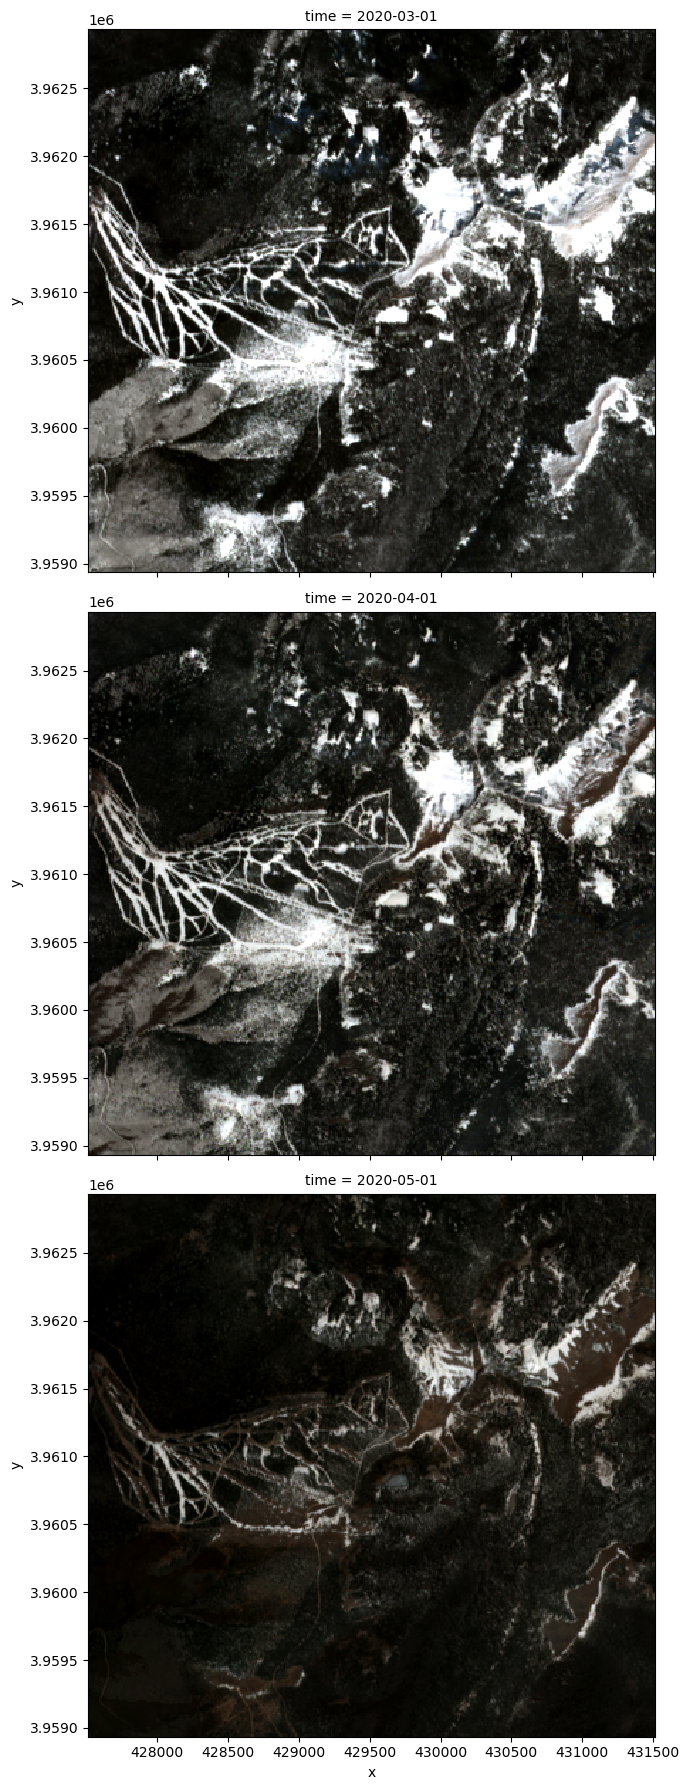

In [12]:
data.plot.imshow(row="time", rgb="band", robust=True, size=6);

In [4]:
import certifi
certifi.where()

'C:\\Users\\lsun\\AppData\\Local\\anaconda3\\envs\\stac\\Lib\\site-packages\\certifi\\cacert.pem'